# FOLLOWING NOTEBOOK IS USED TO PERFORM LAND SUITABILITY ASSESSMENT USING PYTHON

## 1. This cell imports all the necessary Python libraries for spatial data processing, geospatial analysis, raster operations, array computations, and plotting. We centralize imports to avoid repetition:

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import pandas as pd
from datetime import datetime, timedelta
from shapely.geometry import Point

DEM Metadata:
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 6281, 'height': 5564, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]'), 'transform': Affine(12.5, 0.0, 286409.625,
       0.0, -12.5, 2609425.75)}

Detailed Tags:
{'TIFFTAG_SOFTWARE': 'Created with GAMMA Software www.gamma-rs.ch', 'TIFFTAG_DATETIME': '2015:08:17 08:38:58', 'AREA_OR_POINT': 'Point'}

Cell Size:
  Width: 12.5 meters
  Heigh

## 2. Load the Digital Elevation Model (DEM) from a GeoTIFF file and display its metadata and tags to understand its spatial reference, resolution, dimensions, and data type.

In [ ]:
dem_path = "AP_13298_FBD_F0450_RT1.dem.tif"  

with rasterio.open(dem_path) as src:
    print("DEM Metadata:")
    print(src.meta)
    print("\nDetailed Tags:")
    print(src.tags())
    
    transform = src.transform
    pixel_width = transform.a
    pixel_height = -transform.e 
    print(f"\nCell Size:\n  Width: {pixel_width} meters\n  Height: {pixel_height} meters")

    elevation = src.read(1)
    nodata = src.nodata

valid_elevation = elevation[elevation != nodata]

# Calculate and display statistics
print("\nElevation Statistics:")
print(f"  Min:    {np.min(valid_elevation):.2f} meters")
print(f"  Max:    {np.max(valid_elevation):.2f} meters")
print(f"  Mean:   {np.mean(valid_elevation):.2f} meters")
print(f"  Median: {np.median(valid_elevation):.2f} meters")
print(f"  StdDev: {np.std(valid_elevation):.2f} meters")

## 3. Load the area of interest vector file & overlayed for the basemap

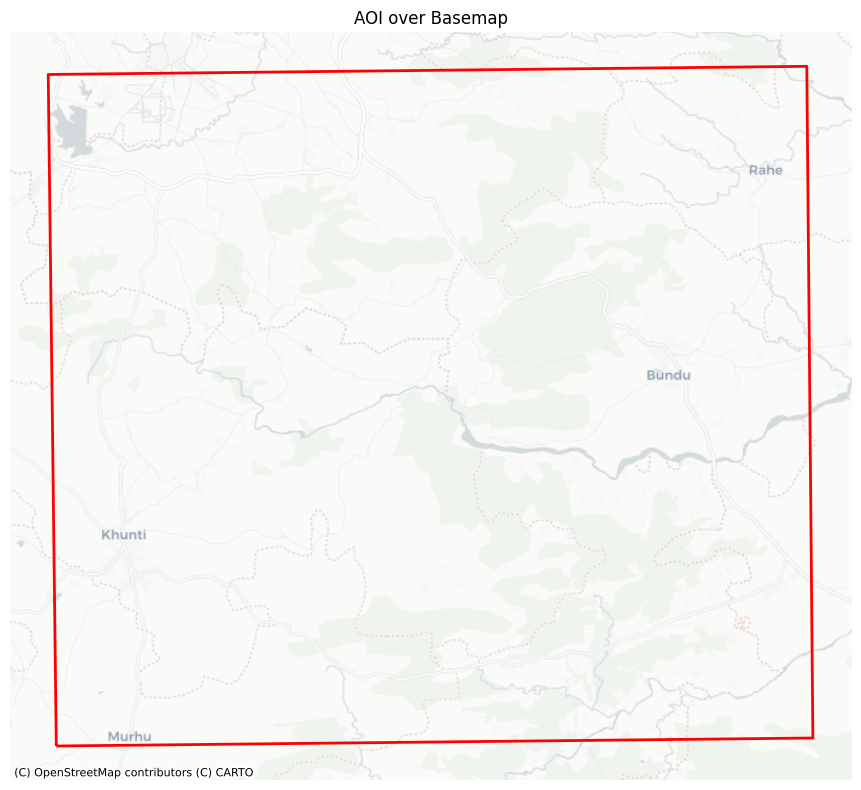

In [ ]:
aoi_path = "AOI2.gpkg"
aoi = gpd.read_file(aoi_path)

aoi_web = aoi.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
aoi_web.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

try:
       ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f"Offline or basemap failed: {e}")
    ax.set_title("AOI (No Basemap - Offline Mode)")

ax.set_axis_off()
plt.title("AOI over Basemap")
plt.tight_layout()
plt.show()


## 4. Clipping the DEM to AOI extent & computing its elevation statistics

In [ ]:
aoi_path = "AOI2.gpkg"  
aoi = gpd.read_file(aoi_path)

aoi = aoi[~aoi.geometry.is_empty & ~aoi.geometry.isna()]

if aoi.empty:
    raise ValueError("No valid geometries found in the AOI GeoDataFrame. Please check the input data.")

with rasterio.open(dem_path) as src:
    aoi = aoi.to_crs(src.crs)  
    out_image, out_transform = mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()
    nodata = src.nodata  

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

output_path = "clipped_DEM.tif"  
with rasterio.open(output_path, 'w', **out_meta) as dst:
    dst.write(out_image)


clipped_data = out_image[0]
valid_data = clipped_data[clipped_data != nodata]

print("\nClipped DEM Elevation Statistics:")
print(f"  Min:    {np.min(valid_data):.2f} meters")
print(f"  Max:    {np.max(valid_data):.2f} meters")
print(f"  Mean:   {np.mean(valid_data):.2f} meters")
print(f"  Median: {np.median(valid_data):.2f} meters")
print(f"  StdDev: {np.std(valid_data):.2f} meters")


Clipped DEM Elevation Statistics:
  Min:    164.00 meters
  Max:    699.00 meters
  Mean:   431.89 meters
  Median: 476.00 meters
  StdDev: 136.72 meters


## 5. Computing elevation histogram 

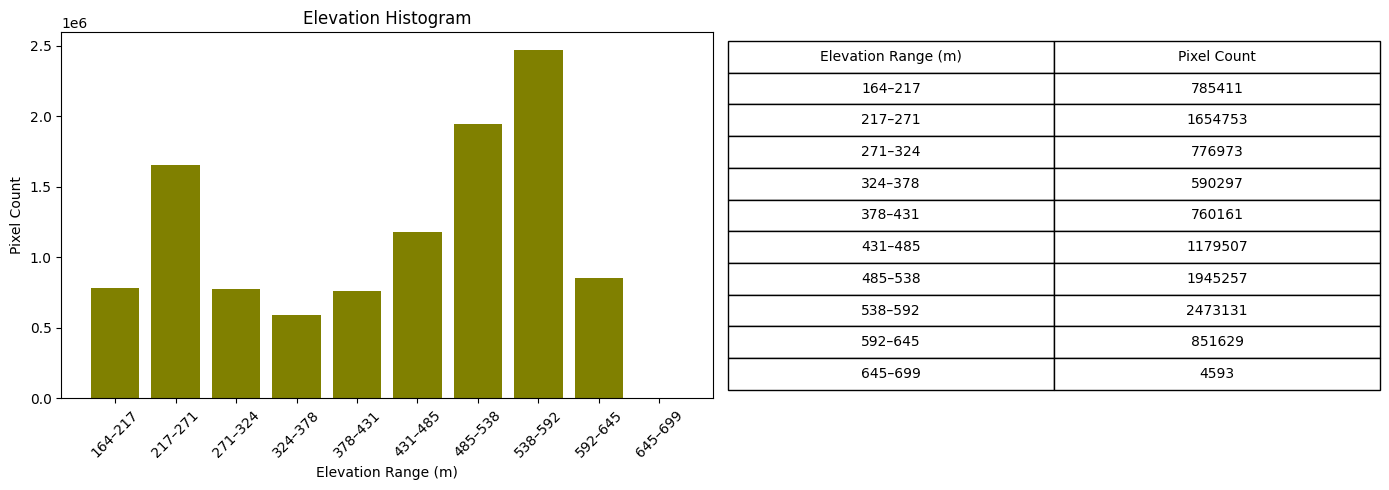

In [ ]:
elevation_data = out_image[0]
elevation_data = elevation_data[elevation_data != src.nodata]

hist_vals, bin_edges = np.histogram(elevation_data, bins=10)

bin_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
hist_df = pd.DataFrame({
    "Elevation Range (m)": bin_labels,
    "Pixel Count": hist_vals
})

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(bin_labels, hist_vals, color='olive')
axs[0].set_title('Elevation Histogram')
axs[0].set_xlabel('Elevation Range (m)')
axs[0].set_ylabel('Pixel Count')
axs[0].tick_params(axis='x', rotation=45)

axs[1].axis('off')
table = axs[1].table(
    cellText=hist_df.values,
    colLabels=hist_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()


## 6. Plotting clipped DEM

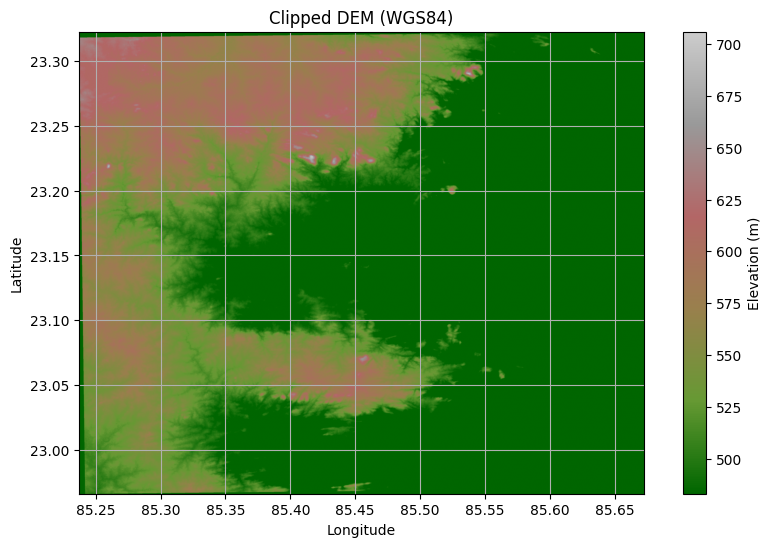

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import LinearSegmentedColormap

dst_crs = 'EPSG:4326'

with rasterio.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=out_image.shape[1],
        width=out_image.shape[2],
        count=1,
        dtype=out_image.dtype,
        crs=src.crs,
        transform=out_transform
    ) as tmp_src:

        tmp_src.write(out_image)
        
        transform, width, height = calculate_default_transform(
            tmp_src.crs, dst_crs, tmp_src.width, tmp_src.height, *tmp_src.bounds)

        kwargs = tmp_src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.MemoryFile() as dst_mem:
            with dst_mem.open(**kwargs) as dst:
                reproject(
                    source=rasterio.band(tmp_src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=tmp_src.transform,
                    src_crs=tmp_src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

                data = dst.read(1)
                bounds = dst.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

elevation_min, elevation_max = 483, 706 
colors = [
    (0.0, (0.0, 0.4, 0.0)),   
    (0.1, (0.2, 0.5, 0.1)),   
    (0.2, (0.4, 0.6, 0.2)),   
    (0.4, (0.6, 0.5, 0.3)),   
    (0.6, (0.7, 0.4, 0.4)),   
    (0.8, (0.6, 0.6, 0.6)),   
    (0.9, (0.7, 0.7, 0.7)),   
    (1.0, (0.8, 0.8, 0.8))    
]
n_bins = 256
cmap_name = 'custom_terrain'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(10, 6))
img = plt.imshow(data, extent=extent, cmap=cm, origin='upper', vmin=elevation_min, vmax=elevation_max)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clipped DEM (WGS84)')
plt.colorbar(img, label='Elevation (m)')
plt.grid(True)
# plt.savefig('clipped_dem.png')

## 7. Reclassifying the DEM into 5 classes & displaying its histogram

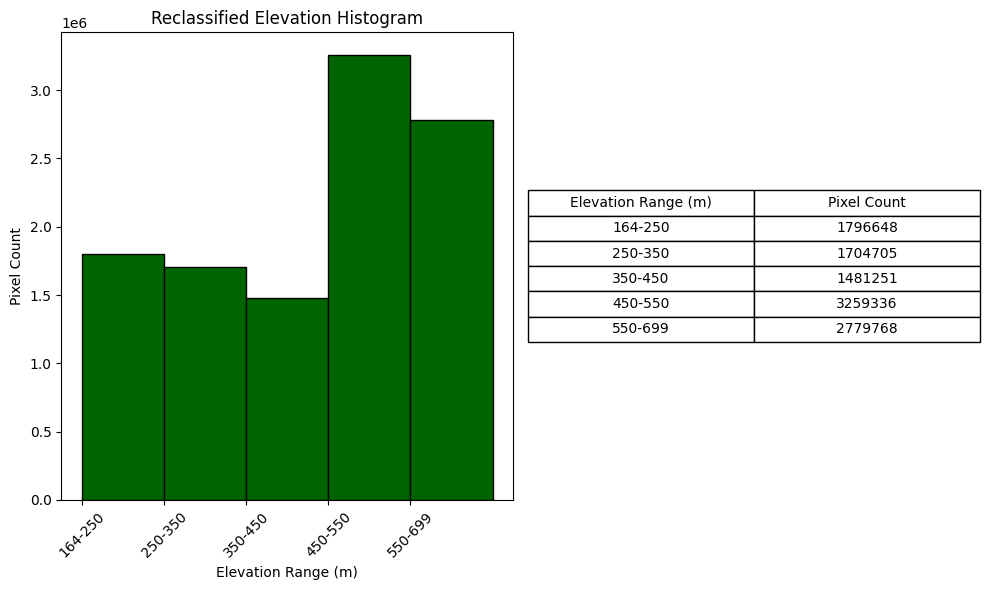

In [ ]:
elevation_ranges = [
    (164, 217, 785411),
    (217, 271, 1654753),
    (271, 324, 776973),
    (324, 378, 590297),
    (378, 431, 760161),
    (431, 485, 1179507),
    (485, 538, 1945257),
    (538, 592, 2473131),
    (592, 645, 851629),
    (645, 699, 4593)
]

class_ranges = [
    (164, 250),  # Class 1
    (250, 350),  # Class 2
    (350, 450),  # Class 3
    (450, 550),  # Class 4
    (550, 699)   # Class 5
]

# Reclassify pixel counts into the 5 classes
class_pixel_counts = [0] * 5
for start, end, count in elevation_ranges:
    for i, (class_start, class_end) in enumerate(class_ranges):
        if start < class_end and end > class_start:
            if start >= class_start and end <= class_end:
                class_pixel_counts[i] += count
            else:
                overlap_start = max(start, class_start)
                overlap_end = min(end, class_end)
                overlap_fraction = (overlap_end - overlap_start) / (end - start)
                class_pixel_counts[i] += int(count * overlap_fraction)

class_labels = [f"{start}-{end}" for start, end in class_ranges]

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
ax1.hist(range(5), weights=class_pixel_counts, bins=5, range=(0, 5), color='darkgreen', edgecolor='black')
ax1.set_xticks(range(5))
ax1.set_xticklabels(class_labels, rotation=45)
ax1.set_xlabel('Elevation Range (m)')
ax1.set_ylabel('Pixel Count')
ax1.set_title('Reclassified Elevation Histogram')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = fig.add_subplot(122)
ax2.axis('off')
table_data = [[f"{start}-{end}", count] for (start, end), count in zip(class_ranges, class_pixel_counts)]
table = ax2.table(cellText=table_data, colLabels=['Elevation Range (m)', 'Pixel Count'], loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig('reclassified_elevation_histogram.png')

## 8. Plotting reclassified DEM

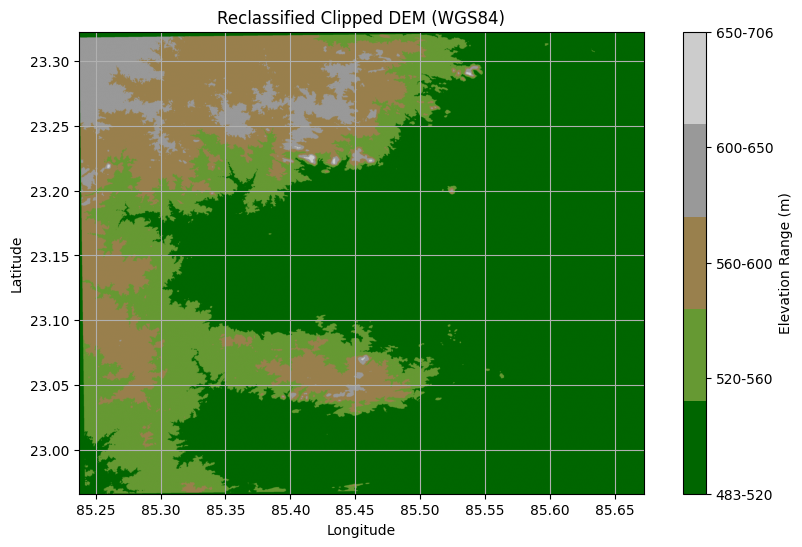

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import ListedColormap

dst_crs = 'EPSG:4326'

with rasterio.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=out_image.shape[1],
        width=out_image.shape[2],
        count=1,
        dtype=out_image.dtype,
        crs=src.crs,
        transform=out_transform
    ) as tmp_src:

        tmp_src.write(out_image)

        transform, width, height = calculate_default_transform(
            tmp_src.crs, dst_crs, tmp_src.width, tmp_src.height, *tmp_src.bounds)

        kwargs = tmp_src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.MemoryFile() as dst_mem:
            with dst_mem.open(**kwargs) as dst:
                reproject(
                    source=rasterio.band(tmp_src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=tmp_src.transform,
                    src_crs=tmp_src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

                data = dst.read(1)
                bounds = dst.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

                bins = [483, 520, 560, 600, 650, 706]  
                class_labels = ['483-520', '520-560', '560-600', '600-650', '650-706'] 

                reclassified_data = np.digitize(data, bins, right=False) - 1  
                reclassified_data = np.clip(reclassified_data, 0, 4)  

                output_path = "reclassified_clipped_DEM.tif"
                reclassified_meta = dst.meta.copy()
                reclassified_meta.update({
                    'dtype': reclassified_data.dtype,
                    'nodata': None  
                })
                with rasterio.open(output_path, 'w', **reclassified_meta) as dst_out:
                    dst_out.write(reclassified_data, 1)

colors = [
    (0.0, 0.4, 0.0),  # Dark green for 483–520 m
    (0.4, 0.6, 0.2),  # Greenish-brown for 520–560 m
    (0.6, 0.5, 0.3),  # Brown for 560–600 m
    (0.6, 0.6, 0.6),  # Light gray for 600–650 m
    (0.8, 0.8, 0.8)   # Lighter gray for 650–706 m
]
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 6))
img = plt.imshow(reclassified_data, extent=extent, cmap=cmap, origin='upper', vmin=0, vmax=4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Reclassified Clipped DEM (WGS84)')

cbar = plt.colorbar(img, ticks=range(5))
cbar.set_label('Elevation Range (m)')
cbar.set_ticks(ticks=range(5), labels=class_labels)
plt.grid(True)
#plt.savefig('reclassified_clipped_dem.png')

## 9. Calculating

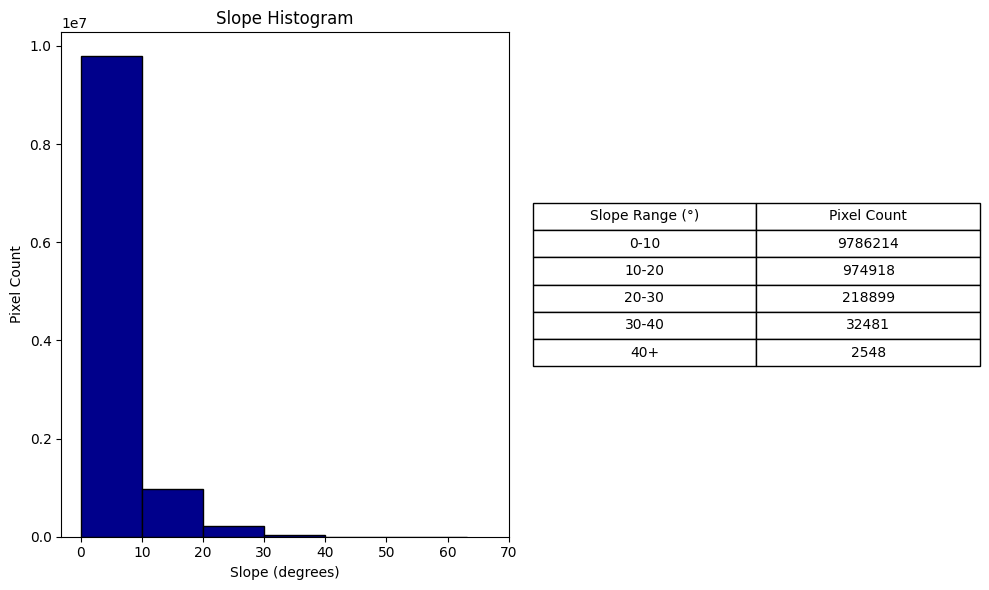

In [ ]:
dem_path = "clipped_DEM.tif"
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  
    transform = src.transform
    nodata = src.nodata

pixel_size_x = transform[0] 
pixel_size_y = abs(transform[4]) 

valid_mask = dem_data != nodata
dem_data = np.where(valid_mask, dem_data, np.nan)

dz_dy, dz_dx = np.gradient(dem_data, pixel_size_y, pixel_size_x)

slope_rad = np.sqrt(dz_dx**2 + dz_dy**2)
slope_rad = np.arctan(slope_rad)  

slope_deg = np.degrees(slope_rad)

slope_valid = slope_deg[~np.isnan(slope_deg)]

bins = [0, 10, 20, 30, 40, np.inf]
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40+']
bin_indices = np.digitize(slope_valid, bins, right=False) - 1
bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)  

pixel_counts = np.zeros(len(bin_labels), dtype=int)
for i in range(len(bin_labels)):
    pixel_counts[i] = np.sum(bin_indices == i)

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
ax1.hist(slope_valid, bins=bins[:-1] + [slope_valid.max()], color='darkblue', edgecolor='black')
ax1.set_xticks(range(0, int(slope_valid.max()) + 10, 10))
ax1.set_xlabel('Slope (degrees)')
ax1.set_ylabel('Pixel Count')
ax1.set_title('Slope Histogram')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = fig.add_subplot(122)
ax2.axis('off')
table_data = [[label, count] for label, count in zip(bin_labels, pixel_counts)]
table = ax2.table(cellText=table_data, colLabels=['Slope Range (°)', 'Pixel Count'], loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
#plt.savefig('slope_histogram.png')

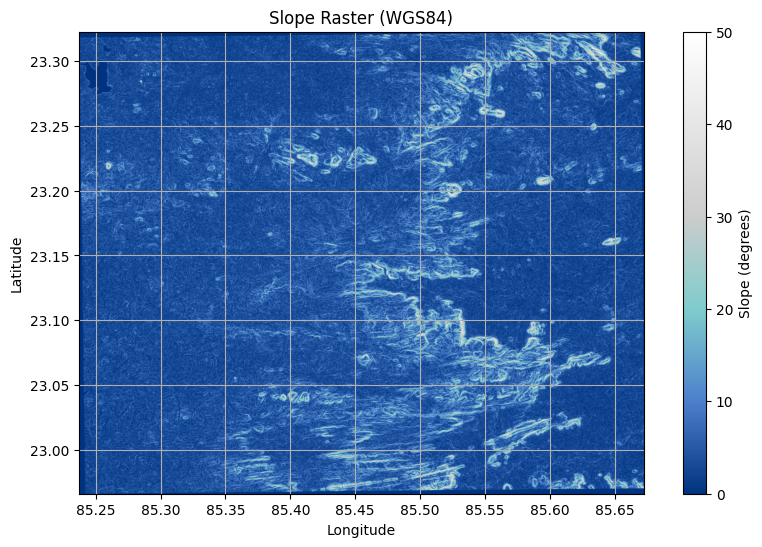

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from rasterio.warp import calculate_default_transform, reproject, Resampling

dem_path = "clipped_dem.tif"
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  
    transform = src.transform
    nodata = src.nodata
    src_crs = src.crs
    meta = src.meta.copy() 

pixel_size_x = transform[0]  
pixel_size_y = abs(transform[4])  

valid_mask = dem_data != nodata
dem_data = np.where(valid_mask, dem_data, np.nan)

dz_dy, dz_dx = np.gradient(dem_data, pixel_size_y, pixel_size_x)

slope_rad = np.sqrt(dz_dx**2 + dz_dy**2)
slope_rad = np.arctan(slope_rad)  

slope_deg = np.degrees(slope_rad)

slope_deg_save = np.where(np.isnan(slope_deg), nodata, slope_deg)

output_path = "slope_raster.tif"
meta.update({
    'dtype': slope_deg_save.dtype,
    'nodata': nodata
})
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(slope_deg_save, 1)

dst_crs = 'EPSG:4326'
with rasterio.MemoryFile() as memfile:
    with memfile.open(
        driver='GTiff',
        height=slope_deg.shape[0],
        width=slope_deg.shape[1],
        count=1,
        dtype=slope_deg.dtype,
        crs=src_crs,
        transform=transform,
        nodata=nodata
    ) as tmp_src:
        tmp_src.write(slope_deg_save, 1)
        transform, width, height = calculate_default_transform(
            tmp_src.crs, dst_crs, tmp_src.width, tmp_src.height, *tmp_src.bounds)

        kwargs = tmp_src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.MemoryFile() as dst_mem:
            with dst_mem.open(**kwargs) as dst:
                reproject(
                    source=rasterio.band(tmp_src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=tmp_src.transform,
                    src_crs=tmp_src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

                slope_deg_reprojected = dst.read(1)
                bounds = dst.bounds
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

slope_min, slope_max = 0, 50  
colors = [
    (0.0, (0.0, 0.2, 0.5)),   # Dark blue for 0–10° (most frequent)
    (0.2, (0.3, 0.5, 0.8)),   # Lighter blue for 10–20°
    (0.4, (0.5, 0.8, 0.8)),   # Cyan for 20–30°
    (0.6, (0.8, 0.8, 0.8)),   # Light gray for 30–40°
    (1.0, (1.0, 1.0, 1.0))    # White for 40+° (least frequent)
]
n_bins = 256
cmap_name = 'custom_slope'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(10, 6))
img = plt.imshow(slope_deg_reprojected, extent=extent, cmap=cm, origin='upper', vmin=slope_min, vmax=slope_max)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope Raster (WGS84)')
plt.colorbar(img, label='Slope (degrees)')
plt.grid(True)
#plt.savefig('slope_raster_plot.png')

In [ ]:
from datetime import datetime, timedelta

df = pd.read_csv('imdlib_rain_2008-01-01_to_2008-12-31_polygon_rain.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)
df['time'] = pd.to_datetime(df['time'])
df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

print("Rainfall Data for July 2008:")
print(df_july.to_string(index=False))

Rainfall Data for July 2008:
                     time   lat   lon       rain
2008-07-01 00:00:00+00:00 23.00 85.25   7.335796
2008-07-01 00:00:00+00:00 23.00 85.50  14.358639
2008-07-01 00:00:00+00:00 23.00 85.75  15.488375
2008-07-01 00:00:00+00:00 23.25 85.25   4.329510
2008-07-01 00:00:00+00:00 23.25 85.50   4.804304
2008-07-01 00:00:00+00:00 23.25 85.75  10.918664
2008-07-02 00:00:00+00:00 23.00 85.25   1.077400
2008-07-02 00:00:00+00:00 23.00 85.50   0.549033
2008-07-02 00:00:00+00:00 23.00 85.75   2.701246
2008-07-02 00:00:00+00:00 23.25 85.25   3.625337
2008-07-02 00:00:00+00:00 23.25 85.50   2.499109
2008-07-02 00:00:00+00:00 23.25 85.75   5.746783
2008-07-03 00:00:00+00:00 23.00 85.25   2.142805
2008-07-03 00:00:00+00:00 23.00 85.50   0.877492
2008-07-03 00:00:00+00:00 23.00 85.75   0.000000
2008-07-03 00:00:00+00:00 23.25 85.25   5.921765
2008-07-03 00:00:00+00:00 23.25 85.50  21.623266
2008-07-03 00:00:00+00:00 23.25 85.75  13.003807
2008-07-04 00:00:00+00:00 23.00 85.25  2

C:\Users\Skywa\AppData\Local\Temp\ipykernel_13900\1672244702.py:82: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


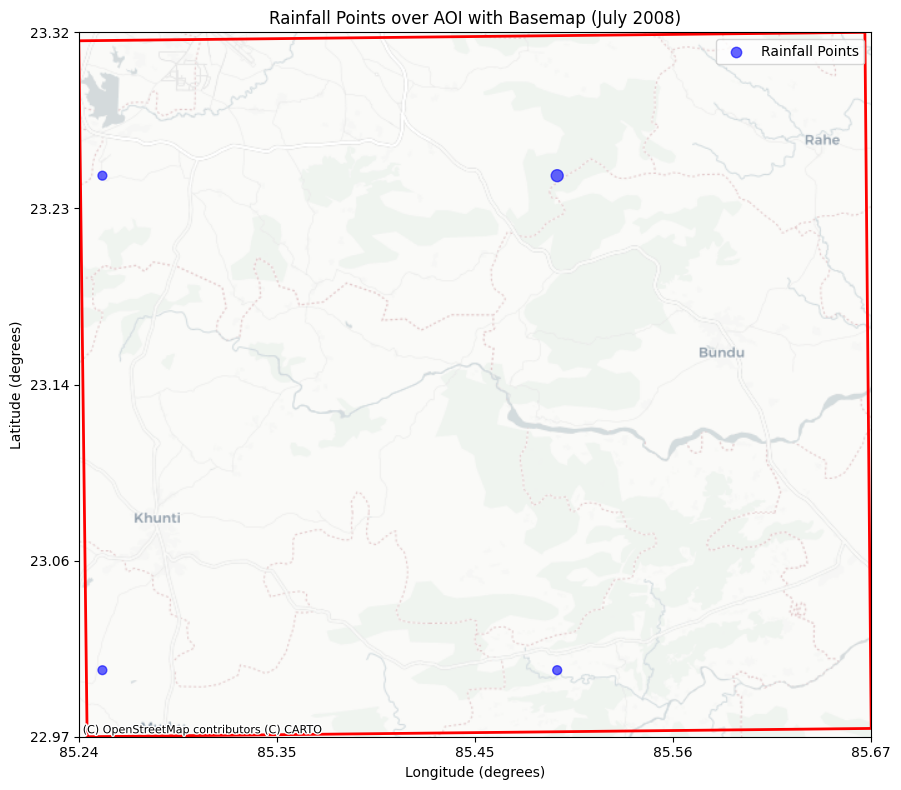

In [ ]:
from datetime import datetime, timedelta
from shapely.geometry import Point
import matplotlib.ticker as mticker
from cartopy.crs import PlateCarree

df = pd.read_csv('imdlib_rain_2008-01-01_to_2008-12-31_polygon_rain.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)
df['time'] = pd.to_datetime(df['time'])

df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

total_rain_july = df_july.groupby(['lat', 'lon'])['rain'].sum().reset_index()

geometry = [Point(lon, lat) for lat, lon in zip(total_rain_july['lat'], total_rain_july['lon'])]
points_gdf = gpd.GeoDataFrame(total_rain_july, geometry=geometry, crs="EPSG:4326")

aoi_path = "AOI2.gpkg"
aoi = gpd.read_file(aoi_path)

aoi_web = aoi.to_crs(epsg=3857)
points_web = points_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
aoi_web.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='AOI')

points_web.plot(ax=ax, markersize=points_gdf['rain'] * 0.1, color='blue', alpha=0.6, label='Rainfall Points')

try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f"Offline or basemap failed: {e}")
    ax.set_title("AOI and Rainfall Points (No Basemap - Offline Mode)")

bounds = aoi_web.total_bounds  # [minx, miny, maxx, maxy] in EPSG:3857
bounds_gdf = gpd.GeoDataFrame(geometry=[Point(bounds[0], bounds[1]), Point(bounds[2], bounds[3])], crs="EPSG:3857")
bounds_latlon = bounds_gdf.to_crs(epsg=4326)
lon_min, lat_min = bounds_latlon.geometry[0].x, bounds_latlon.geometry[0].y
lon_max, lat_max = bounds_latlon.geometry[1].x, bounds_latlon.geometry[1].y

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

ax.set_xticks(np.linspace(bounds[0], bounds[2], 5))
ax.set_yticks(np.linspace(bounds[1], bounds[3], 5))
xticks_latlon = gpd.GeoDataFrame(geometry=[Point(x, bounds[1]) for x in ax.get_xticks()], crs="EPSG:3857").to_crs(epsg=4326)
yticks_latlon = gpd.GeoDataFrame(geometry=[Point(bounds[0], y) for y in ax.get_yticks()], crs="EPSG:3857").to_crs(epsg=4326)
ax.set_xticklabels([f"{p.x:.2f}" for p in xticks_latlon.geometry])
ax.set_yticklabels([f"{p.y:.2f}" for p in yticks_latlon.geometry])

ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

plt.title("Rainfall Points over AOI with Basemap (July 2008)")
plt.legend()
plt.tight_layout()

# Save the plot
#plt.savefig('rainfall_over_aoi.png')

AOI loaded successfully. Contents:
                                            geometry
0                                               None
1  POLYGON Z ((85.24161 22.96633 0, 85.23701 23.3...
Found 4 points inside the AOI for interpolation.
Existing IDW_Rainfall.tif deleted successfully.
IDW interpolation saved as 'IDW_Rainfall.tif'


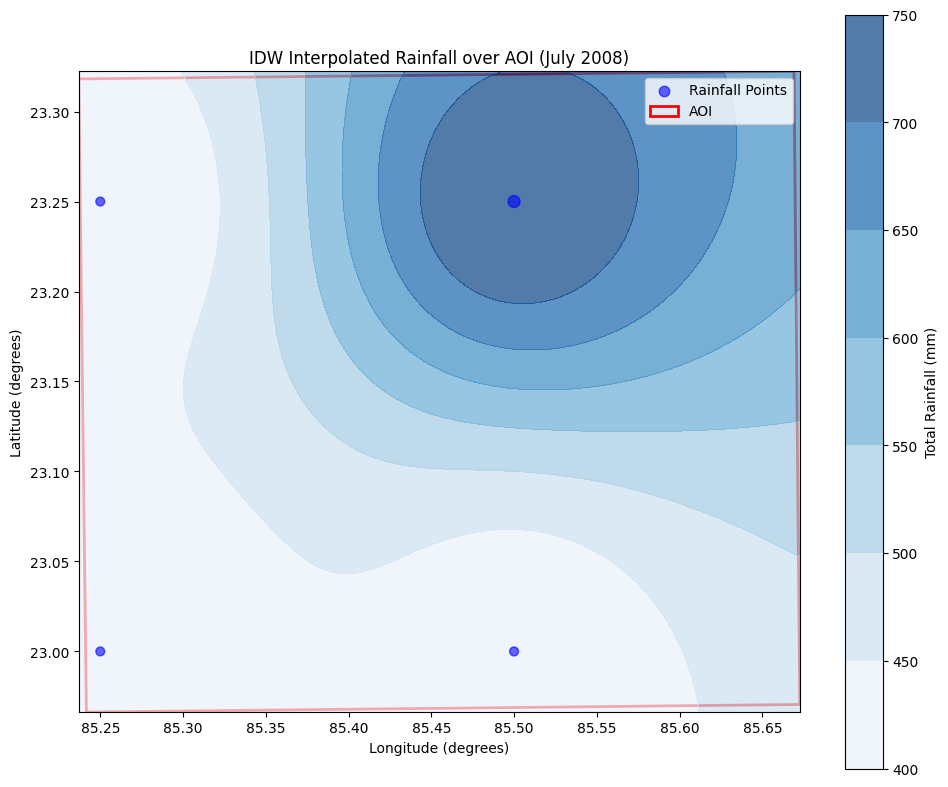

In [ ]:
from shapely.geometry import Point
from rasterio.transform import from_bounds
from matplotlib.patches import Patch

df = pd.read_csv('imdlib_rain_2008-01-01_to_2008-12-31_polygon_rain.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)
df['time'] = pd.to_datetime(df['time'])

df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

total_rain_july = df_july.groupby(['lat', 'lon'])['rain'].sum().reset_index()

geometry = [Point(lon, lat) for lat, lon in zip(total_rain_july['lat'], total_rain_july['lon'])]
points_gdf = gpd.GeoDataFrame(total_rain_july, geometry=geometry, crs="EPSG:4326")

aoi_path = "AOI2.gpkg"
try:
    aoi = gpd.read_file(aoi_path)
    print("AOI loaded successfully. Contents:")
    print(aoi)
except Exception as e:
    print(f"Failed to load AOI file: {e}")
    raise

if aoi.empty:
    print("AOI GeoDataFrame is empty. Please check the AOI2.gpkg file.")
    raise ValueError("AOI GeoDataFrame is empty")

aoi = aoi[aoi.geometry.notna() & ~aoi.geometry.is_empty]
if aoi.empty:
    print("AOI GeoDataFrame contains no valid geometries after filtering.")
    raise ValueError("No valid geometries in AOI")

aoi = aoi.to_crs(epsg=4326)

aoi_geometry = aoi.geometry.union_all()  
points_inside_aoi = points_gdf[points_gdf.geometry.within(aoi_geometry)]

if points_inside_aoi.empty:
    print("No rainfall points are inside the AOI polygon. Cannot perform interpolation.")
else:
    print(f"Found {len(points_inside_aoi)} points inside the AOI for interpolation.")

    bounds = aoi.total_bounds  
    lon_min, lat_min, lon_max, lat_max = bounds

    lat_fine = np.linspace(lat_min, lat_max, 100)
    lon_fine = np.linspace(lon_min, lon_max, 100)
    lon_grid, lat_grid = np.meshgrid(lon_fine, lat_fine)

    def idw_interpolate(lon, lat, points, values, power=2):
        interpolated_values = np.zeros_like(lon)
        for i in range(lon.shape[0]):
            for j in range(lon.shape[1]):
                x, y = lon[i, j], lat[i, j]
                distances = np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2)
                if np.min(distances) == 0:
                    idx = np.argmin(distances)
                    interpolated_values[i, j] = values[idx]
                else:
                    weights = 1 / distances**power
                    interpolated_values[i, j] = np.sum(values * weights) / np.sum(weights)
        return interpolated_values

    points = points_inside_aoi[['lon', 'lat']].values
    values = points_inside_aoi['rain'].values

    rain_interp = idw_interpolate(lon_grid, lat_grid, points, values, power=2)

    rain_interp_flipped = np.flipud(rain_interp)
    height, width = rain_interp.shape
    transform = from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)
    crs = 'EPSG:4326'

    output_file = 'IDW_Rainfall.tif'
    try:
        if os.path.exists(output_file):
            os.remove(output_file)
            print(f"Existing {output_file} deleted successfully.")
    except PermissionError as e:
        print(f"Cannot delete existing {output_file}: {e}")
        print("Please ensure the file is not open in another program (e.g., QGIS) and try again.")
        raise

    try:
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=rain_interp.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(rain_interp_flipped, 1)
        print(f"IDW interpolation saved as '{output_file}'")
    except Exception as e:
        print(f"Failed to save raster: {e}")
        raise


    fig, ax = plt.subplots(figsize=(10, 8))

    aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    rain_contour = ax.contourf(lon_grid, lat_grid, rain_interp, cmap='Blues', alpha=0.7)
    plt.colorbar(rain_contour, ax=ax, label='Total Rainfall (mm)')

    points_inside_aoi.plot(ax=ax, markersize=points_inside_aoi['rain'] * 0.1, color='blue', alpha=0.6, label='Rainfall Points')

    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')

    aoi_patch = Patch(facecolor='none', edgecolor='red', linewidth=2, label='AOI')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(aoi_patch)
    plt.legend(handles=handles)

    plt.title("IDW Interpolated Rainfall over AOI (July 2008)")
    plt.tight_layout()

    # Save the plot
    #plt.savefig('idw_rainfall_over_aoi.png')

In [ ]:

df = pd.read_csv('2imdlib_tmean_2008-01-01_to_2008-12-31_polygon_tmean.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)

df['time'] = pd.to_datetime(df['time'])

df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

print("Temperature Data for July 2008:")
print(df_july.to_string(index=False))

Temperature Data for July 2008:
                     time       lat       lon      tmax      tmin     tmean
2008-07-01 00:00:00+00:00 23.016437 85.525525 28.910000 24.320000 26.615000
2008-07-01 00:00:00+00:00 23.010252 85.472409 28.459999 23.540001 26.000000
2008-07-02 00:00:00+00:00 23.257232 85.551821 30.600000 24.090000 27.345000
2008-07-02 00:00:00+00:00 23.195358 85.387771 31.559999 23.690001 27.625000
2008-07-03 00:00:00+00:00 23.295701 85.475451 32.299999 23.709999 28.004999
2008-07-03 00:00:00+00:00 22.971347 85.592258 32.139999 23.660000 27.900000
2008-07-04 00:00:00+00:00 23.039052 85.564394 33.240002 24.540001 28.890001
2008-07-04 00:00:00+00:00 23.316377 85.652796 32.959999 24.049999 28.504999
2008-07-05 00:00:00+00:00 23.256793 85.343324 31.959999 24.700001 28.330000
2008-07-05 00:00:00+00:00 23.128613 85.340550 32.119999 24.280001 28.200000
2008-07-06 00:00:00+00:00 23.164337 85.584437 31.930000 25.170000 28.550000
2008-07-06 00:00:00+00:00 23.128568 85.385640 32.110001 

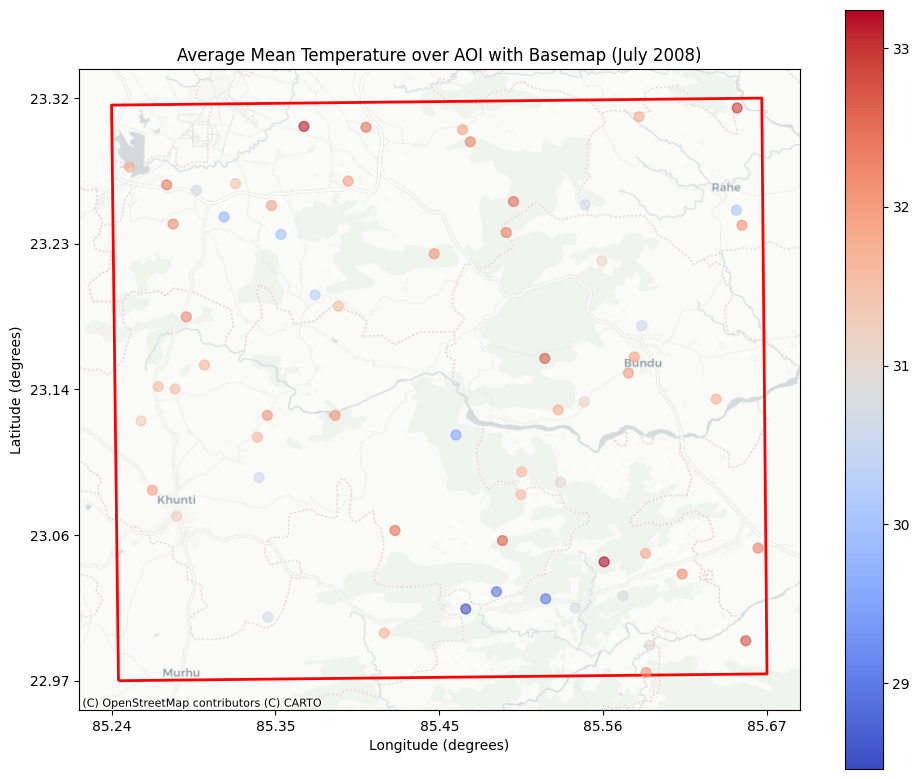

In [ ]:
df = pd.read_csv('2imdlib_tmean_2008-01-01_to_2008-12-31_polygon_tmean.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)
df['time'] = pd.to_datetime(df['time'])

df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

avg_tmean_july = df_july.groupby(['lat', 'lon'])['tmax'].mean().reset_index()

geometry = [Point(lon, lat) for lat, lon in zip(avg_tmean_july['lat'], avg_tmean_july['lon'])]
points_gdf = gpd.GeoDataFrame(avg_tmean_july, geometry=geometry, crs="EPSG:4326")

aoi_path = "AOI2.gpkg"
aoi = gpd.read_file(aoi_path)

aoi_web = aoi.to_crs(epsg=3857)
points_web = points_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

aoi_web.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

points_web.plot(ax=ax, markersize=50, column='tmax', cmap='coolwarm', alpha=0.6, legend=True)

try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
except Exception as e:
    print(f"Offline or basemap failed: {e}")
    ax.set_title("AOI and Temperature Points (No Basemap - Offline Mode)")

aoi_bounds = aoi_web.total_bounds  
points_bounds = points_web.total_bounds  

combined_minx = min(aoi_bounds[0], points_bounds[0])
combined_miny = min(aoi_bounds[1], points_bounds[1])
combined_maxx = max(aoi_bounds[2], points_bounds[2])
combined_maxy = max(aoi_bounds[3], points_bounds[3])

x_range = combined_maxx - combined_minx
y_range = combined_maxy - combined_miny
buffer_x = x_range * 0.05
buffer_y = y_range * 0.05

ax.set_xlim(combined_minx - buffer_x, combined_maxx + buffer_x)
ax.set_ylim(combined_miny - buffer_y, combined_maxy + buffer_y)

ax.set_xticks(np.linspace(combined_minx, combined_maxx, 5))
ax.set_yticks(np.linspace(combined_miny, combined_maxy, 5))
xticks_latlon = gpd.GeoDataFrame(geometry=[Point(x, combined_miny) for x in ax.get_xticks()], crs="EPSG:3857").to_crs(epsg=4326)
yticks_latlon = gpd.GeoDataFrame(geometry=[Point(combined_minx, y) for y in ax.get_yticks()], crs="EPSG:3857").to_crs(epsg=4326)
ax.set_xticklabels([f"{p.x:.2f}" for p in xticks_latlon.geometry])
ax.set_yticklabels([f"{p.y:.2f}" for p in yticks_latlon.geometry])

ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

plt.title("Average Mean Temperature over AOI with Basemap (July 2008)")
plt.tight_layout()

# Save the plot (uncomment to save)
# plt.savefig('temperature_over_aoi.png')

AOI loaded successfully. Contents:
                                            geometry
0                                               None
1  POLYGON Z ((85.24161 22.96633 0, 85.23701 23.3...
Found 62 points inside the AOI for interpolation.
Existing IDW_Temperature(Mean).tif deleted successfully.
IDW interpolation saved as 'IDW_Temperature(Mean).tif'


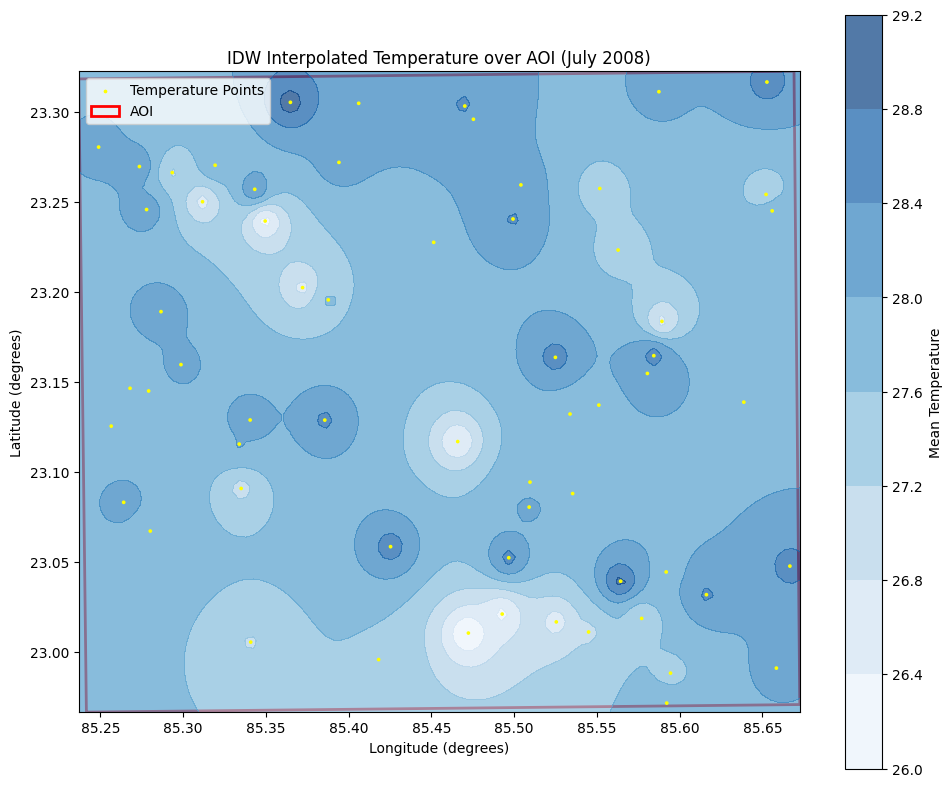

In [ ]:
from rasterio.transform import from_bounds
from matplotlib.patches import Patch

df = pd.read_csv('2imdlib_tmean_2008-01-01_to_2008-12-31_polygon_tmean.csv')

def fix_time_column(time_str):
    if 'T24:00:00Z' in time_str:
        date_part = time_str.split('T')[0]
        date = datetime.strptime(date_part, '%Y-%m-%d')
        next_day = date + timedelta(days=1)
        return next_day.strftime('%Y-%m-%dT00:00:00Z')
    return time_str

df['time'] = df['time'].apply(fix_time_column)
df['time'] = pd.to_datetime(df['time'])

df_july = df[(df['time'].dt.month == 7) & (df['time'].dt.year == 2008)]

total_temp_july = df_july.groupby(['lat', 'lon'])['tmean'].sum().reset_index()

geometry = [Point(lon, lat) for lat, lon in zip(total_temp_july['lat'], total_temp_july['lon'])]
points_gdf = gpd.GeoDataFrame(total_temp_july, geometry=geometry, crs="EPSG:4326")

aoi_path = "AOI2.gpkg"
try:
    aoi = gpd.read_file(aoi_path)
    print("AOI loaded successfully. Contents:")
    print(aoi)
except Exception as e:
    print(f"Failed to load AOI file: {e}")
    raise

if aoi.empty:
    print("AOI GeoDataFrame is empty. Please check the AOI2.gpkg file.")
    raise ValueError("AOI GeoDataFrame is empty")

aoi = aoi[aoi.geometry.notna() & ~aoi.geometry.is_empty]
if aoi.empty:
    print("AOI GeoDataFrame contains no valid geometries after filtering.")
    raise ValueError("No valid geometries in AOI")

aoi = aoi.to_crs(epsg=4326)

aoi_geometry = aoi.geometry.union_all()  
points_inside_aoi = points_gdf[points_gdf.geometry.within(aoi_geometry)]

if points_inside_aoi.empty:
    print("No rainfall points are inside the AOI polygon. Cannot perform interpolation.")
else:
    print(f"Found {len(points_inside_aoi)} points inside the AOI for interpolation.")

    bounds = aoi.total_bounds 
    lon_min, lat_min, lon_max, lat_max = bounds

    lat_fine = np.linspace(lat_min, lat_max, 100)
    lon_fine = np.linspace(lon_min, lon_max, 100)
    lon_grid, lat_grid = np.meshgrid(lon_fine, lat_fine)

    def idw_interpolate(lon, lat, points, values, power=2):
        interpolated_values = np.zeros_like(lon)
        for i in range(lon.shape[0]):
            for j in range(lon.shape[1]):
                x, y = lon[i, j], lat[i, j]
                distances = np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2)
                if np.min(distances) == 0:
                    idx = np.argmin(distances)
                    interpolated_values[i, j] = values[idx]
                else:
                    weights = 1 / distances**power
                    interpolated_values[i, j] = np.sum(values * weights) / np.sum(weights)
        return interpolated_values

    
    points = points_inside_aoi[['lon', 'lat']].values
    values = points_inside_aoi['tmean'].values

    rain_interp = idw_interpolate(lon_grid, lat_grid, points, values, power=2)

    rain_interp_flipped = np.flipud(rain_interp)
    height, width = rain_interp.shape
    transform = from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)
    crs = 'EPSG:4326'

    output_file = 'IDW_Temperature(Mean).tif'
    try:
        if os.path.exists(output_file):
            os.remove(output_file)
            print(f"Existing {output_file} deleted successfully.")
    except PermissionError as e:
        print(f"Cannot delete existing {output_file}: {e}")
        print("Please ensure the file is not open in another program (e.g., QGIS) and try again.")
        raise

    try:
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=rain_interp.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(rain_interp_flipped, 1)
        print(f"IDW interpolation saved as '{output_file}'")
    except Exception as e:
        print(f"Failed to save raster: {e}")
        raise

    fig, ax = plt.subplots(figsize=(10, 8))

    aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    rain_contour = ax.contourf(lon_grid, lat_grid, rain_interp, cmap='Blues', alpha=0.7)
    plt.colorbar(rain_contour, ax=ax, label='Mean Temperature')

    points_inside_aoi.plot(ax=ax, markersize=points_inside_aoi['tmean'] * 0.1, color='yellow', alpha=1, label='Temperature Points')

    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')

    aoi_patch = Patch(facecolor='none', edgecolor='red', linewidth=2, label='AOI')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(aoi_patch)
    plt.legend(handles=handles)

    plt.title("IDW Interpolated Temperature over AOI (July 2008)")
    plt.tight_layout()

    # Save the plot
    #plt.savefig('idw_rainfall_over_aoi.png')

In [25]:
shapefile_path = 'Soil_Data.gpkg'
gdf = gpd.read_file(shapefile_path)
gdf

SNUM  FAOSOIL            DOMSOI PHASE1 PHASE2 MISCLU1 MISCLU2 PERMAFROST  \
0  3729     I-Ne         Lithosols   None   None       0       0          0   
1  3819  Nd50-2b  Distric Nitosols   None   None       0       0          0   
2  3729     I-Ne         Lithosols   None   None       0       0          0   

   CNTCODE CNTNAME     SQKM COUNTRY  \
0      100      IN    409.0   INDIA   
1      100      IN  10176.0   INDIA   
2      100      IN    816.0   INDIA   

                                            geometry  
0  POLYGON Z ((85.37039 22.97006 0, 85.3519 22.97...  
1  POLYGON Z ((85.61853 23.32074 0, 85.62107 23.2...  
2  POLYGON Z ((85.63935 23.25346 0, 85.62107 23.2...

Original CRS: EPSG:4326


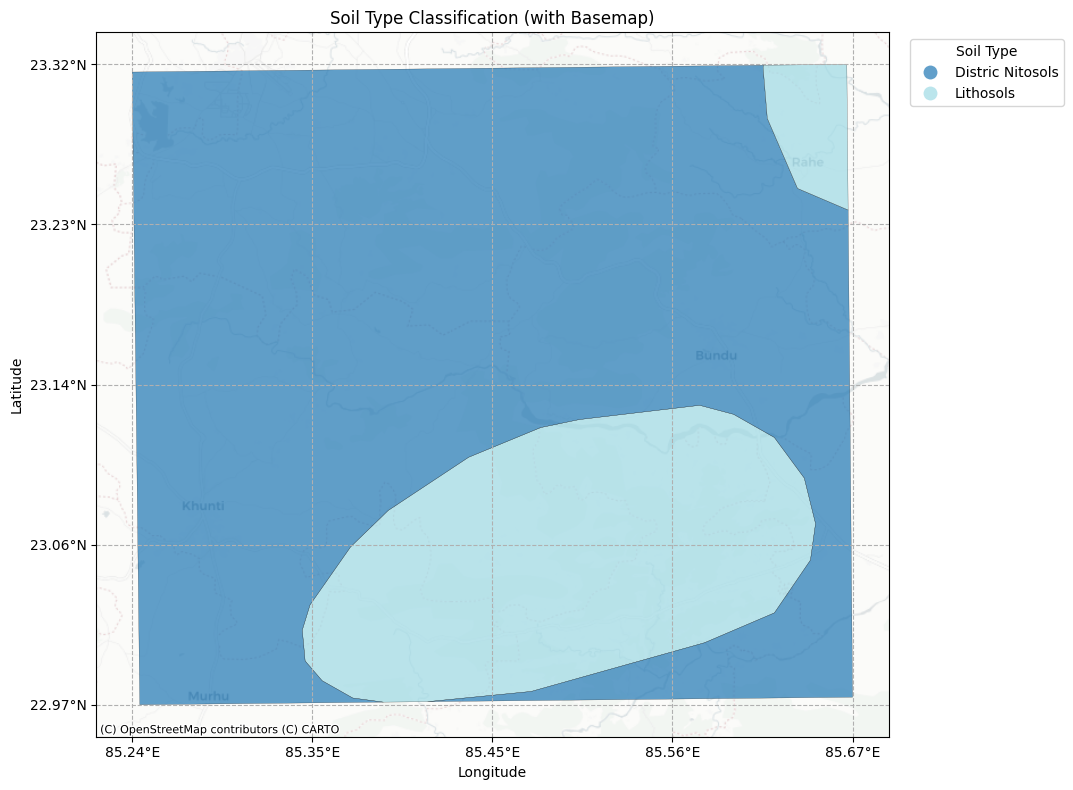

In [ ]:
from pyproj import Transformer

shapefile_path = 'Soil_Data.gpkg'
gdf = gpd.read_file(shapefile_path)

print("Original CRS:", gdf.crs)

gdf_web = gdf.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(12, 8))

gdf_web.plot(column='DOMSOI', 
            ax=ax,
            legend=True,
            legend_kwds={'bbox_to_anchor': (1.23, 1), 'title': 'Soil Type'},
            cmap='tab20',  
            edgecolor='black',
            linewidth=0.2,
            alpha=0.7)  

try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)
    basemap_status = "with Basemap"
except Exception as e:
    print(f"Basemap failed: {e}")
    basemap_status = "without Basemap (offline mode)"

bounds = gdf_web.total_bounds  

x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
buffer_x = x_range * 0.05
buffer_y = y_range * 0.05

ax.set_xlim(bounds[0] - buffer_x, bounds[2] + buffer_x)
ax.set_ylim(bounds[1] - buffer_y, bounds[3] + buffer_y)

ax.set_xticks(np.linspace(bounds[0], bounds[2], 5))
ax.set_yticks(np.linspace(bounds[1], bounds[3], 5))

transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

xticks_lon = [transformer.transform(x, bounds[1])[0] for x in ax.get_xticks()]
yticks_lat = [transformer.transform(bounds[0], y)[1] for y in ax.get_yticks()]

ax.set_xticklabels([f"{lon:.2f}°E" if lon >=0 else f"{-lon:.2f}°W" for lon in xticks_lon])
ax.set_yticklabels([f"{lat:.2f}°N" if lat >=0 else f"{-lat:.2f}°S" for lat in yticks_lat])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Soil Type Classification ({basemap_status})')

ax.grid(True, linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

Original CRS: EPSG:4326
Number of features: 3
Total bounds (WGS84): [85.23701296 22.9663342  85.67262157 23.32238032]
Class mapping: {'Lithosols': 1, 'Distric Nitosols': 2}
Raster dimensions: 5334x4741 (resolution: 10m)
Raster contains values: [0 1 2]
Successfully loaded CartoDB Positron basemap


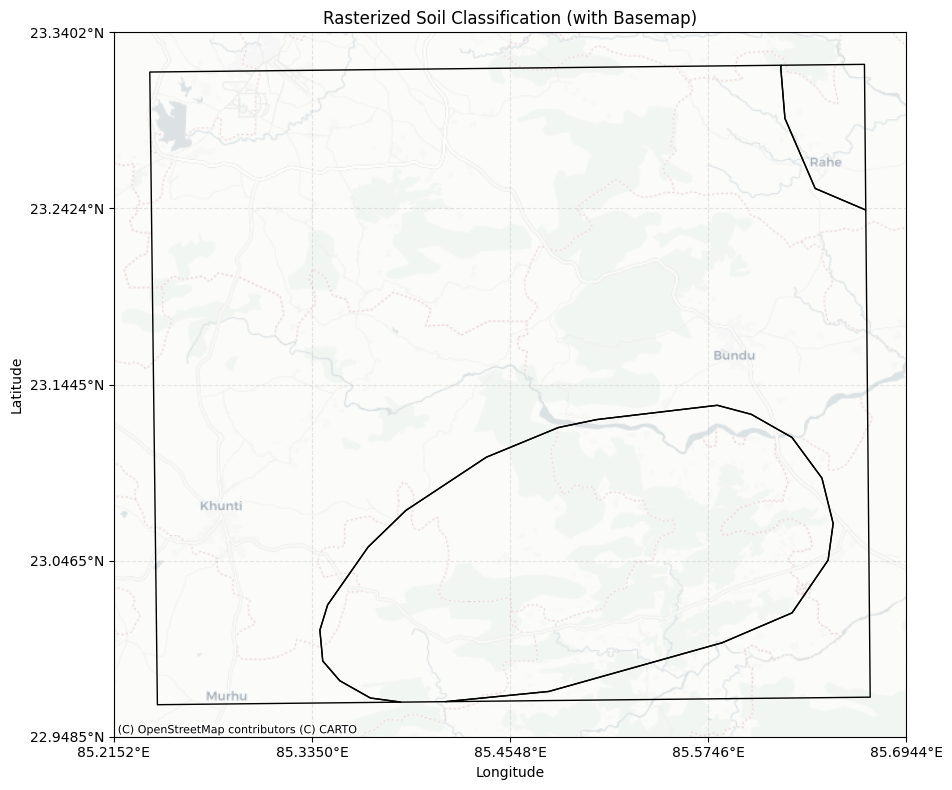

In [ ]:
soil_gdf = gpd.read_file('Soil_Data.gpkg')
print(f"Original CRS: {soil_gdf.crs}")
print(f"Number of features: {len(soil_gdf)}")
print(f"Total bounds (WGS84): {soil_gdf.total_bounds}")

if len(soil_gdf) == 0:
    raise ValueError("No features found in the GeoPackage file")
if any(np.isinf(soil_gdf.total_bounds)):
    raise ValueError("Data contains infinite bounds - check your geometry")

soil_web = soil_gdf.to_crs('EPSG:3857')

bounds = soil_web.total_bounds
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
buffer_x = x_range * 0.05
buffer_y = y_range * 0.05

web_bounds = [
    bounds[0] - buffer_x,
    bounds[1] - buffer_y,
    bounds[2] + buffer_x,
    bounds[3] + buffer_y
]

if web_bounds[0] >= web_bounds[2] or web_bounds[1] >= web_bounds[3]:
    raise ValueError(f"Invalid bounds after reprojection: {web_bounds}")

unique_classes = soil_web['DOMSOI'].unique()
class_mapping = {cls: i+1 for i, cls in enumerate(unique_classes)}
soil_web['class_num'] = soil_web['DOMSOI'].map(class_mapping)
print(f"Class mapping: {class_mapping}")

x_res = y_res = 10  
width = int((web_bounds[2] - web_bounds[0]) / x_res)
height = int((web_bounds[3] - web_bounds[1]) / y_res)

print(f"Raster dimensions: {width}x{height} (resolution: {x_res}m)")

if width <= 0 or height <= 0:
    raise ValueError(f"Invalid raster dimensions: {width}x{height}. Check your data bounds and resolution.")

transform = from_bounds(*web_bounds, width, height)

shapes = []
for geom, value in zip(soil_web.geometry, soil_web['class_num']):
    if geom.is_empty:
        print("Warning: Empty geometry found")
        continue
    shapes.append((geom, value))

if not shapes:
    raise ValueError("No valid geometries found for rasterization")

raster = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  
    dtype=np.uint8
)

fig, ax = plt.subplots(figsize=(12, 8))

unique_values = np.unique(raster)
print(f"Raster contains values: {unique_values}")
if len(unique_values) <= 1:  
    print("Warning: Raster may not have properly captured all classes")

im = ax.imshow(raster, 
               extent=web_bounds, 
               cmap='tab10',
               alpha=0.7,
               vmin=0,
               vmax=len(unique_classes))

soil_web.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

ax.set_xlim(web_bounds[0], web_bounds[2])
ax.set_ylim(web_bounds[1], web_bounds[3])

try:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)
    print("Successfully loaded CartoDB Positron basemap")
    basemap_loaded = True
except Exception as e:
    print(f"Failed to load basemap: {str(e)}")
    basemap_loaded = False
    ax.set_facecolor('#f0f0f0')  

x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
buffer_x = x_range * 0.05
buffer_y = y_range * 0.05

transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

x_ticks = np.linspace(web_bounds[0], web_bounds[2], 5)
y_ticks = np.linspace(web_bounds[1], web_bounds[3], 5)

x_labels = [f"{transformer.transform(x, web_bounds[1])[0]:.4f}°E" for x in x_ticks]
y_labels = [f"{transformer.transform(web_bounds[0], y)[1]:.4f}°N" for y in y_ticks]

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
title = 'Rasterized Soil Classification' + (' (with Basemap)' if basemap_loaded else ' (without Basemap)')
ax.set_title(title)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

✅ Reprojected raster saved to: LULC_2008_clipped_wgs84.tif
✅ Clipped raster saved to: C:\Users\Skywa\Desktop\FCF_India\LandSuitablityAssessment\AP_13298_FBD_F0450_RT1\LULC_2008_clipped.tif


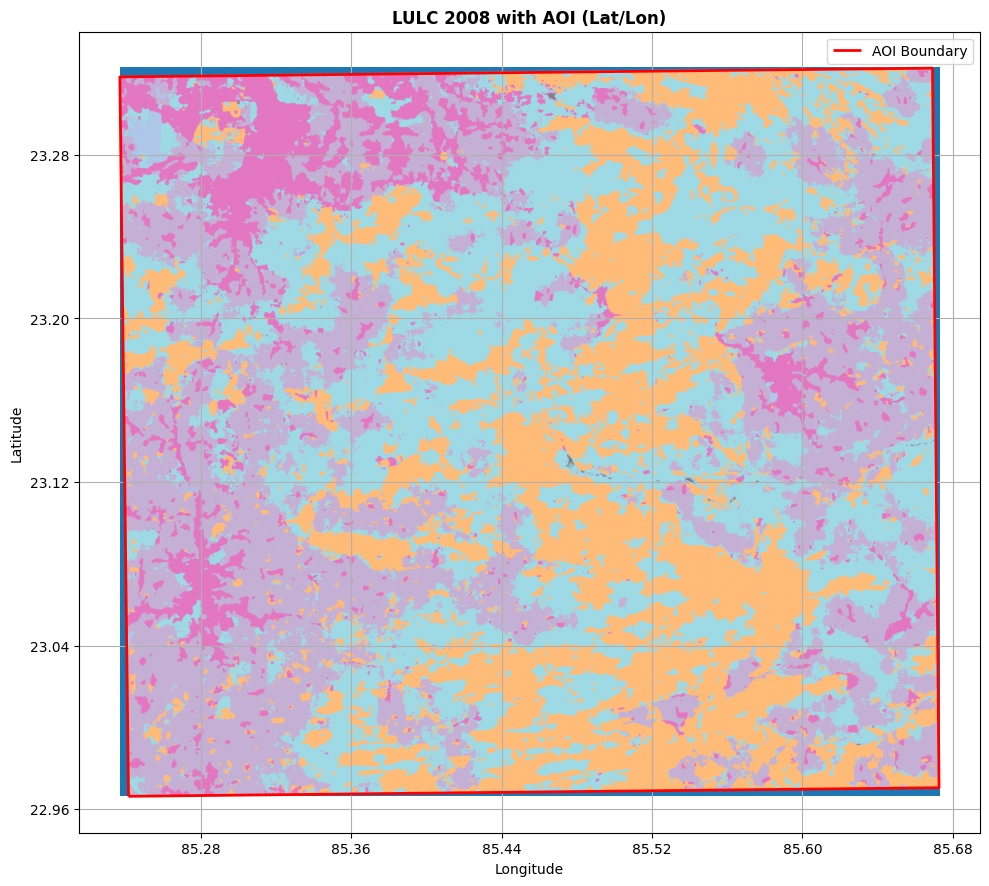

In [ ]:
aoi = gpd.read_file("AOI2.gpkg")

aoi = aoi[aoi.is_valid & ~aoi.geometry.is_empty]

geoms = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

with rasterio.open("LULC_2008.tif") as src:
    if aoi.crs != src.crs:
        aoi = aoi.to_crs(src.crs)
    
    out_image, out_transform = mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'
with rasterio.open(out_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    reprojected_path = 'LULC_2008_clipped_wgs84.tif'
    with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print(f"Reprojected raster saved to: {reprojected_path}")

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

out_path = "LULC_2008_clipped.tif"
with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f" Clipped raster saved to: {os.path.abspath(out_path)}")

aoi_latlon = aoi.to_crs("EPSG:4326")

with rasterio.open(reprojected_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))

    show(src.read(1), transform=src.transform, ax=ax, cmap='tab20', title="LULC 2008 with AOI (Lat/Lon)")

    aoi_latlon = aoi.to_crs("EPSG:4326")

    aoi_latlon.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label="AOI Boundary")

    bounds = aoi_latlon.total_bounds  # [minx, miny, maxx, maxy]
    x_range = bounds[2] - bounds[0]
    y_range = bounds[3] - bounds[1]
    buffer_x = x_range * 0.05
    buffer_y = y_range * 0.05

    ax.set_xlim(bounds[0] - buffer_x, bounds[2] + buffer_x)
    ax.set_ylim(bounds[1] - buffer_y, bounds[3] + buffer_y)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




C:\Users\Skywa\AppData\Local\Temp\ipykernel_13900\3976925924.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(hist_df['Label'], rotation=90, fontsize=11)


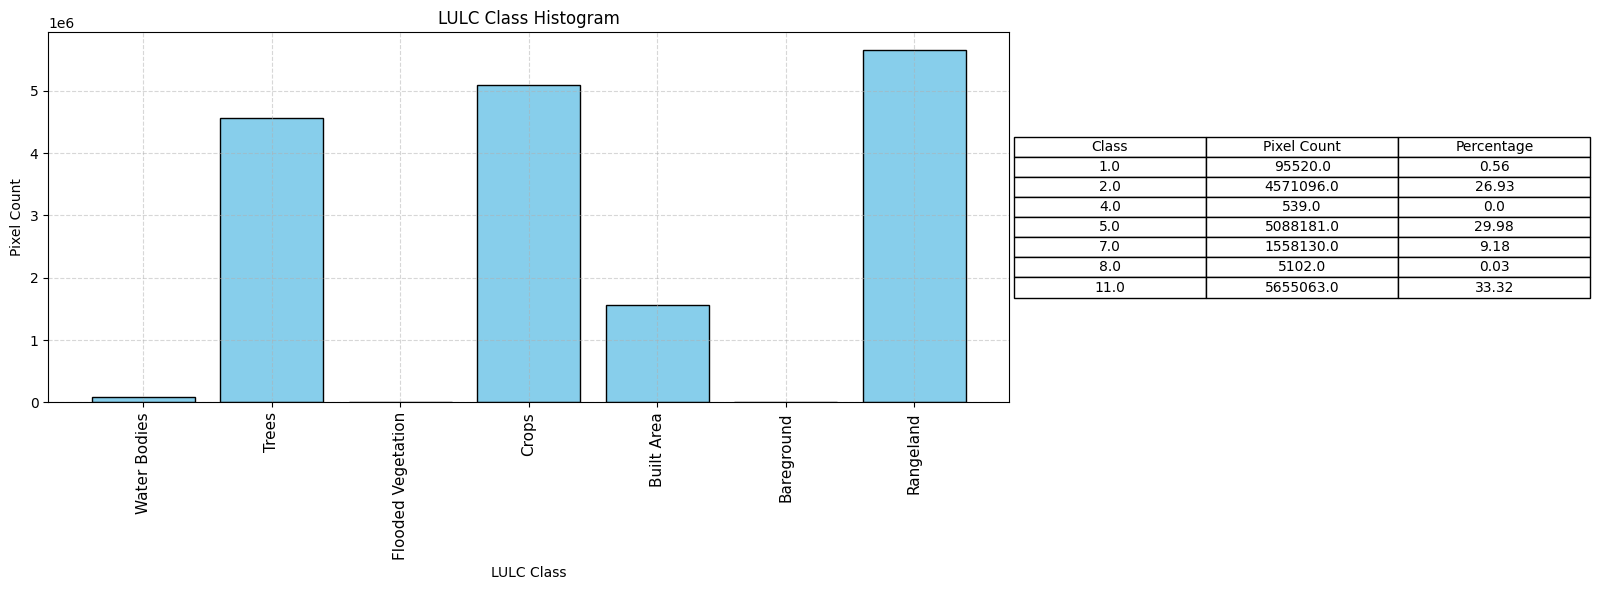

In [ ]:
class_labels = {
    1: "Water Bodies",
    2: "Trees",
    4: "Flooded Vegetation",
    5: "Crops",
    7: "Built Area",
    8: "Bareground",
    11: "Rangeland"
}

with rasterio.open('LULC_2008_clipped_wgs84.tif') as src:
    raster = src.read(1)
raster = raster[raster != src.nodata]

unique, counts = np.unique(raster, return_counts=True)

hist_df = pd.DataFrame({
    'Class': unique.astype(int),
    'Pixel Count': counts,
})
hist_df['Percentage'] = (hist_df['Pixel Count'] / hist_df['Pixel Count'].sum() * 100).round(2)

hist_df['Class'] = hist_df['Class'].astype(int)
hist_df['Pixel Count'] = hist_df['Pixel Count'].astype(int)

hist_df['Label'] = hist_df['Class'].map(class_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

ax1.bar(hist_df['Label'], hist_df['Pixel Count'], color='skyblue', edgecolor='black')
ax1.set_title('LULC Class Histogram')
ax1.set_xlabel('LULC Class')
ax1.set_ylabel('Pixel Count')
ax1.set_xticklabels(hist_df['Label'], rotation=90, fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.5)

table_df = hist_df[['Class', 'Pixel Count', 'Percentage']]
ax2.axis('off')
table = ax2.table(cellText=table_df.values,
                  colLabels=table_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.tight_layout()
plt.show()


In [ ]:
raster_files = {
    'slope': 'slope_raster.tif',
    'landuse': 'LULC_2008_clipped.tif',
    'soil': 'soil_raster.tif',
    'rainfall': 'IDW_Rainfall.tif',
    'temperature': 'IDW_Temperature(Mean).tif',
    'elevation': 'reclassified_clipped_DEM.tif'
}

weights = {
    'slope': 0.15,
    'landuse': 0.3,
    'soil': 0.2,
    'rainfall': 0.15,
    'temperature': 0.05,
    'elevation': 0.15
}

for criterion, filepath in raster_files.items():
    with rasterio.open(filepath) as src:
        print(f"{criterion}:")
        print(f"  Shape: {src.shape}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  CRS: {src.crs}")

slope:
  Shape: (3118, 3537)
  Resolution: (12.5, 12.5)
  Bounds: BoundingBox(left=319722.125, bottom=2540863.25, right=363934.625, top=2579838.25)
  CRS: EPSG:32645
landuse:
  Shape: (3897, 4421)
  Resolution: (10.0, 10.0)
  Bounds: BoundingBox(left=319730.0, bottom=2540870.0, right=363940.0, top=2579840.0)
  CRS: EPSG:32645
soil:
  Shape: (86, 96)
  Resolution: (500.0, 500.0)
  Bounds: BoundingBox(left=9488540.879410796, bottom=2628051.9213571353, right=9536540.879410796, top=2671051.9213571353)
  CRS: EPSG:3857
rainfall:
  Shape: (100, 100)
  Resolution: (0.004356086095312577, 0.0035604612605159504)
  Bounds: BoundingBox(left=85.23701295967604, bottom=22.96633419584732, right=85.6726215692073, top=23.322380321898915)
  CRS: EPSG:4326
temperature:
  Shape: (100, 100)
  Resolution: (0.004356086095312577, 0.0035604612605159504)
  Bounds: BoundingBox(left=85.23701295967604, bottom=22.96633419584732, right=85.6726215692073, top=23.322380321898915)
  CRS: EPSG:4326
elevation:
  Shape: (30

In [69]:
weighted_sum = None

for criterion, filepath in raster_files.items():
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(float)
        weight = weights[criterion]
        
        # Initialize the weighted_sum array
        if weighted_sum is None:
            weighted_sum = np.zeros_like(data, dtype=float)
            profile = src.profile  # Save metadata for saving output

        weighted_sum += data * weight


ValueError: operands could not be broadcast together with shapes (3118,3537) (3897,4421) (3118,3537) 